In [ ]:
from pydub import AudioSegment
import os

orig_folder = "bird_voices"
mod_folder = "bird_voices_mod"
f_format = "mp3"
mp3_files = [f for f in os.listdir(orig_folder) if f.lower().endswith(".mp3")]

for mp3_file in mp3_files:

    f = AudioSegment.from_file(
        os.path.join(orig_folder, mp3_file),
        f_format
    )

    # Оставляем часть файла с 3 секунды без голоса диктора
    f = f[3000:]

    f.export(
        os.path.join(mod_folder, mp3_file),
        f_format
    )

print("Успешная обрезка аудио")

Успешная обрезка аудио


In [25]:
import os
import numpy as np
import librosa
from tqdm import tqdm

# Настройки
input_dir = "bird_voices_mod"
output_dir = "mel_data"
segment_length = 4.0        # 4 секунды
overlap = 0.5               # 50% перекрытие
sample_rate = 16000
n_mels = 64

os.makedirs(output_dir, exist_ok=True)

# Аугментации
def time_shift(y, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(y))
    return np.roll(y, shift)

def add_noise(y, noise_level=0.005):
    noise = np.random.randn(len(y)) * noise_level
    return y + noise

def random_volume(y, low=0.8, high=1.2):
    factor = np.random.uniform(low, high)
    return y * factor

def pitch_shift(y, sr, n_steps=2):
    y = y.astype(np.float32)
    steps = np.random.uniform(-n_steps, n_steps)
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=steps)

def time_stretch(y, rate_range=(0.9, 1.1)):
    y = y.astype(np.float32)
    rate = np.random.uniform(*rate_range)
    y_stretched = librosa.effects.time_stretch(y=y, rate=rate)
    if len(y_stretched) > len(y):
        y_stretched = y_stretched[:len(y)]
    else:
        y_stretched = np.pad(y_stretched, (0, len(y)-len(y_stretched)))
    return y_stretched

# Аугментация на уровне спектрограммы
def freq_mask(mel_db, F=8):
    f = np.random.randint(0, F)
    f0 = np.random.randint(0, mel_db.shape[0] - f)
    mel_db[f0:f0+f, :] = 0
    return mel_db

def time_mask(mel_db, T=10):
    t = np.random.randint(0, T)
    t0 = np.random.randint(0, mel_db.shape[1] - t)
    mel_db[:, t0:t0+t] = 0
    return mel_db

def process_audio(file_path, label):
    """Обработать аудио с аугментациями"""
    y, sr = librosa.load(file_path, sr=sample_rate, mono=True)
    y = librosa.util.normalize(y)

    # Параметры сегментации
    step = int(segment_length * sample_rate * (1 - overlap))
    seg_len = int(segment_length * sample_rate)
    total_len = len(y)
    if total_len < seg_len:
        y = np.pad(y, (0, seg_len - total_len))
    num_segments = max(1, (total_len - seg_len) // step + 1)

    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    for i in range(num_segments):
        start = i * step
        end = start + seg_len
        segment = y[start:end]

        # Сохраняем оригинал
        mel = librosa.feature.melspectrogram(y=segment, sr=sample_rate, n_mels=n_mels, fmax=8000)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = (mel_db - np.mean(mel_db)) / (np.std(mel_db) + 1e-6)
        base = os.path.splitext(os.path.basename(file_path))[0]
        out_path = os.path.join(label_dir, f"{base}_orig_{i}.npy")
        np.save(out_path, mel_db.astype(np.float32))

    # Проверка: если сегментов меньше 15, создаём дополнительные аугментированные сегменты
    if num_segments < 15:
        num_extra = 15 - num_segments
        for j in range(num_extra):
            # Выбираем случайный сегмент из существующих
            idx = np.random.randint(0, num_segments)
            start = idx * step
            end = start + seg_len
            aug_segment = y[start:end]

            # Применяем случайные аугментации к аудио
            if np.random.rand() < 0.5:
                aug_segment = time_shift(aug_segment, 0.1)
            if np.random.rand() < 0.5:
                aug_segment = add_noise(aug_segment, 0.003)
            if np.random.rand() < 0.5:
                aug_segment = random_volume(aug_segment)
            if np.random.rand() < 0.3:
                aug_segment = pitch_shift(aug_segment, sample_rate)
            if np.random.rand() < 0.3:
                aug_segment = time_stretch(aug_segment, (0.9, 1.1))

            mel = librosa.feature.melspectrogram(y=aug_segment, sr=sample_rate, n_mels=n_mels, fmax=8000)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            mel_db = (mel_db - np.mean(mel_db)) / (np.std(mel_db) + 1e-6)

            # Применяем случайные аугментации к спектрограмме
            if np.random.rand() < 0.5:
                mel_db = freq_mask(mel_db, F=8)
            if np.random.rand() < 0.5:
                mel_db = time_mask(mel_db, T=10)

            out_path_aug = os.path.join(label_dir, f"{base}_extra_{j}.npy")
            np.save(out_path_aug, mel_db.astype(np.float32))


# Обработка всех файлов
for fname in tqdm(os.listdir(input_dir)):
    if not fname.endswith(".mp3"):
        continue
    label = os.path.splitext(fname)[0]
    fpath = os.path.join(input_dir, fname)
    process_audio(fpath, label)

print("✅ Обработка завершена! Все сегменты сохранены в", output_dir)


100%|██████████| 127/127 [00:51<00:00,  2.48it/s]

✅ Обработка завершена! Все сегменты сохранены в mel_data


In [26]:
import numpy as np
import glob
import os


def load_mel_dataset(root_dir):
    """Загрузить датасет из мел-спектрограмм"""
    X, y = [], []
    labels = sorted(os.listdir(root_dir))
    label_to_idx = {lbl: i for i, lbl in enumerate(labels)}

    for lbl in labels:
        files = glob.glob(os.path.join(root_dir, lbl, "*.npy"))
        for f in files:
            mel = np.load(f)
            X.append(mel)
            y.append(label_to_idx[lbl])

    X = np.array(X)[..., np.newaxis]  # Добавляем канал
    y = np.array(y)
    return X, y


X, y = load_mel_dataset("mel_data")
print(X.shape, y.shape)


(5121, 64, 126, 1) (5121,)


In [27]:
import tensorflow as tf


def pairwise_distance(embeddings, squared=False):
    """Вычислить евклидово расстояние между эмбедингами"""
    dot_product = tf.matmul(embeddings, embeddings, transpose_b=True)
    square_norm = tf.linalg.diag_part(dot_product)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)
    distances = tf.maximum(distances, 0.0)
    if not squared:
        mask = tf.equal(distances, 0.0)
        distances = tf.sqrt(distances + tf.cast(mask, tf.float32) * 1e-16)
    return distances


def triplet_semihard_loss(y_true, y_pred, margin=0.2):
    """Вычислить triplet semi-hard потери"""
    labels = tf.reshape(y_true, [-1])
    pdist_matrix = pairwise_distance(y_pred, squared=True)

    adjacency = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Позитивная маска (но исключающая сравнение с самим собой)
    mask_positives = tf.cast(adjacency, tf.float32) - tf.eye(tf.shape(labels)[0])

    # Вычислить положительные расстояния
    pos_dist = tf.multiply(mask_positives, pdist_matrix)
    hardest_pos_dist = tf.reduce_max(pos_dist, axis=1, keepdims=True)

    # Условие: pos < neg < pos + margin
    condition = tf.logical_and(
        pdist_matrix > hardest_pos_dist,
        pdist_matrix < hardest_pos_dist + margin
    )

    mask_condition = tf.cast(condition, tf.float32)

    semi_hard_negatives = pdist_matrix + (1.0 - mask_condition) * 1e12
    semi_hard_neg_dist = tf.reduce_min(semi_hard_negatives, axis=1, keepdims=True)

    # Triplet semi-hard потеря
    loss = tf.maximum(hardest_pos_dist - semi_hard_neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)


In [28]:
import tensorflow as tf
import keras

# Проверяем устройство на наличие CPU/GPU
print(tf.config.list_physical_devices())


def create_embedding_model():
    """Создать модель (эмбеддер)"""
    inp = tf.keras.Input(shape=(64, 126, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128)(x)

    # Кастомный слой
    @keras.saving.register_keras_serializable()
    class L2NormLayer(tf.keras.layers.Layer):
        def call(self, inputs):
            return tf.math.l2_normalize(inputs, axis=1)

    # Нормализация через кастомный слой
    out = L2NormLayer()(x)

    return tf.keras.Model(inp, out)


embedding_model = create_embedding_model()

# Triplet semi-hard loss - самый оптимальный вариант потерь
loss_fn = triplet_semihard_loss

embedding_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=loss_fn
)

embedding_model.fit(
    X, y,
    batch_size=64,    # Если используется CPU => лучше использовать маленький batch
    epochs=25
)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Epoch 1/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.1205
Epoch 2/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.0950
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0859
Epoch 4/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0856
Epoch 5/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0800
Epoch 6/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0787
Epoch 7/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0780
Epoch 8/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0774
Epoch 9/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0775
Epoch 10/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0759
Epoch 11/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0719
Epoch 12/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 0.0748
Epoch 13/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0735
Epoch 14/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss

In [5]:
# Сохраняем обученную модель (эмбеддер)
embedding_model.save("embedding_model.keras")


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


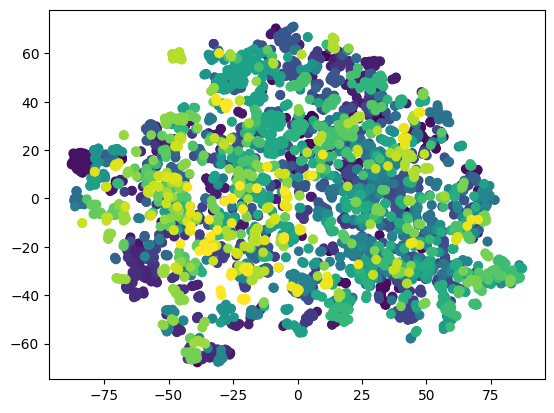

In [ ]:
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Загружаем обученную модель (эмбеддер)
embedding_model = tf.keras.models.load_model(
    "embedding_model.keras",
    compile=False
)

# Получаем эмбединги для датасета
emb = embedding_model.predict(X)

# Проверяем эмбединги на корректность с помощью визуального представления
emb2d = TSNE(n_components=2).fit_transform(emb)
plt.scatter(emb2d[:,0], emb2d[:,1], c=y)
plt.show()


In [15]:
import tensorflow as tf

# Загружаем обученную модель (эмбеддер)
embedding_model = tf.keras.models.load_model(
    "embedding_model.keras",
    compile=False
)

# Получаем эмбединги для датасета
emb = embedding_model.predict(X)

# Примеры расстояний внутри класса и между классами
d1 = tf.norm(emb[0] - emb[1]).numpy()
d2 = tf.norm(emb[0] - emb[-1]).numpy()
print(d1, d2)

# Матрица попарных расстояний
dist_matrix = pairwise_distance(emb)

mask = y[:, None] == y[None, :]  # True там, где один класс

# Верхний треугольник, чтобы не дублировать
triu_indices = np.triu_indices_from(dist_matrix, k=1)

intra_dists = dist_matrix.numpy()[triu_indices][mask[triu_indices]]
inter_dists = dist_matrix.numpy()[triu_indices][~mask[triu_indices]]

print("Среднее внутри:", np.mean(intra_dists))
print("Среднее между:", np.mean(inter_dists))


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
0.5436544 1.6701351
Среднее внутри: 0.7587183
Среднее между: 1.2014886
